In [1]:
import torch
from torch import nn
from torch.distributions import Categorical, Normal
from trainer import Trainer

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
elif torch.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print("You are using device: %s" % device)

You are using device: cuda:0


In [3]:
class YourNN(nn.Module):
    """
    Model of your choice. You can implement any model you want.
    """

    def __init__(self, state_size: int, action_size: int, str_env: str):
        super().__init__()

        self.str_env = str_env

        self.lin1 = nn.Linear(in_features=state_size, out_features=64)
        self.lin2 = nn.Linear(in_features=64, out_features=128)
        self.lin3 = nn.Linear(in_features=128, out_features=256)

        # A fully connected layer to get logits for pi
        if str_env == "CartPole-v1":
            self.pi_logits = nn.Linear(in_features=256, out_features=action_size)
        else:
            self.pi_loc = nn.Linear(in_features=256, out_features=action_size)
            self.pi_scale = nn.Parameter(torch.zeros(action_size))

        # A fully connected layer to get value function
        self.value = nn.Linear(in_features=256, out_features=1)

        self.activation = nn.ReLU()
        

    def forward(self, obs: torch.Tensor):
        h = self.activation(self.lin1(obs))
        h = self.activation(self.lin2(h))
        h = self.activation(self.lin3(h))

        if self.str_env == "CartPole-v1":
            pi = Categorical(logits=self.pi_logits(h))
        else:
            mu = self.pi_loc(h)
            sigma = torch.exp(self.pi_scale).expand_as(mu)
            pi = Normal(loc=mu, scale=sigma)
        value = self.value(h).reshape(-1)

        return pi, value

In [4]:
str_env = "Humanoid-v5"
# str_env = "CartPole-v1"

In [5]:
# Configurations
configs = {
    # Number of updates
    'updates': 1000,
    # Number of epochs to train the model with sampled data.
    'epochs': 8,
    # Number of worker processes
    'N': 8,
    # Number of steps to run on each process for a single update
    'T': 64,
    # Number of mini batches
    'batches': 4,
    # Value loss coefficient.
    'value_loss_coef': 0.5,
    # Entropy bonus coefficient.
    'entropy_bonus_coef': 0.01,
    # Clip range.
    'clip_range': 0.1,
    # Learning rate.
    'learning_rate': 1e-4,
    # Model to use
    'model': YourNN(4, 2, str_env) if str_env == "CartPole-v1" else YourNN(348, 17, str_env),
    # Device to use for training
    'device': device,
    # Environment to use
    'str_env': str_env
}

# Initialize the trainer
trainer = Trainer(**configs)

In [ ]:
# Run and monitor the experiment
trainer.run_training_loop()

# Stop the workers
trainer.destroy()

  3%|▎         | 30/1000 [00:06<03:22,  4.80it/s]

In [ ]:
if device != torch.device("cuda:0") or str_env == "CartPole-v1":
    trainer.log_video(str_env)

Video recorded with duration 143 frames.
MoviePy - Building video results/CartPole-v1.mp4.
MoviePy - Writing video results/CartPole-v1.mp4



MoviePy - Done !
MoviePy - video ready results/CartPole-v1.mp4


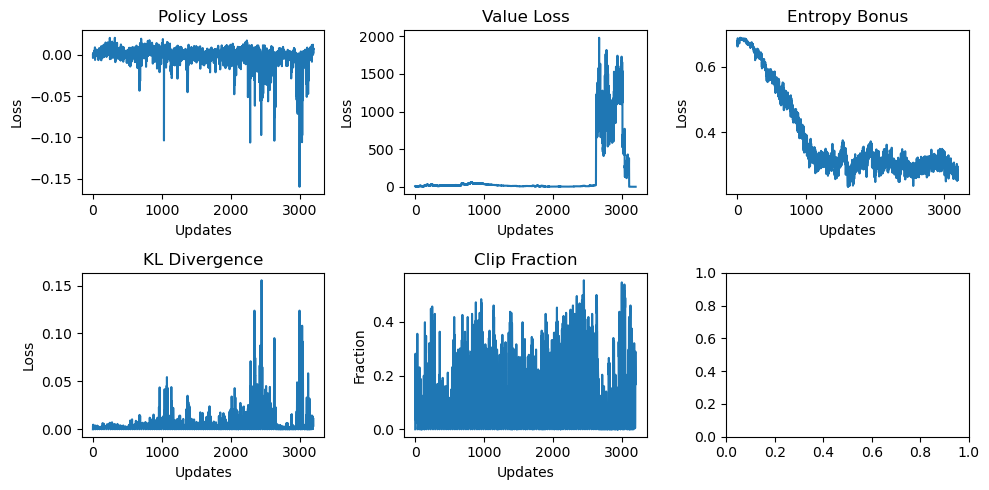

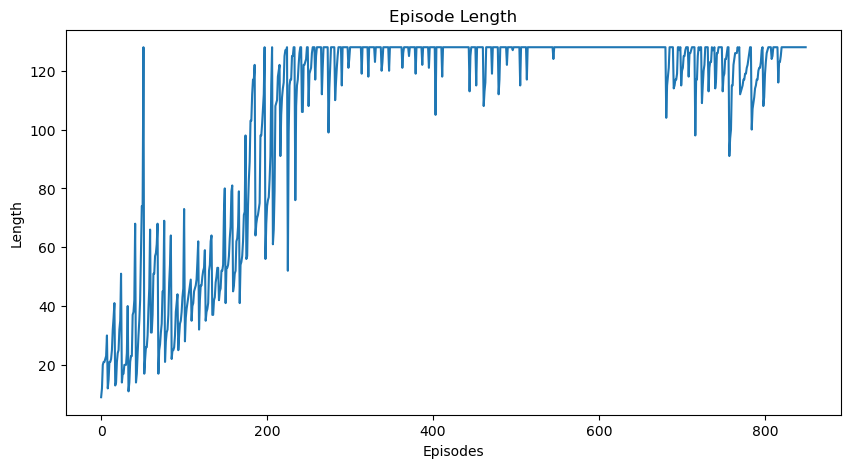

In [ ]:
trainer.plot()